# Лабораторная работа №2 — Линейная классификация

**Тема:** Сравнение логистической регрессии с деревьями (RandomForestClassifier) и градиентным бустингом (XGBoost) на задаче классификации.

## Цели

- Построить, оптимизировать и оценить классификаторы.
- Понять интерпретацию признаков (веса, permutation importance).
- Освоить расширение и отбор признаков (feature tuning).
- Изучить влияние регуляризации, калибровки и гиперпараметров.

## Условия

- numpy, pandas, scikit-learn, XGBoost
- использовать тот же датасет, что в ЛР1 (если возможно), но с целевой переменной для классификации

## План (пункты лабораторной)

1. **Подготовка данных + Feature Tuning**
   - Стратифицированное разбиение; обработка пропусков; OneHotEncoder для категориальных, StandardScaler для численных; базовый feature engineering (минимум 3 новых признака).
2. **Метрики**
   - Accuracy, Precision/Recall/F1 (macro/weighted), ROC-AUC, PR-AUC (для дисбаланса), LogLoss; confusion matrix.
3. **Базовая логистическая регрессия**
   - Pipeline: препроцессинг + LogisticRegression(penalty="l2"); вывести все метрики.
4. **Улучшение логистической регрессии**
   - Тюнинг C, class_weight="balanced", подбор порога по валидации, калибровка вероятностей (CalibratedClassifierCV), сравнение метрик до/после.
5. **RandomForestClassifier**
   - Базовая и тюнинг (n_estimators, max_depth, min_samples_leaf, max_features); метрики как в п.2.
6. **XGBoostClassifier**
   - Базовая и тюнинг (learning_rate, n_estimators, max_depth, subsample, colsample_bytree; early stopping); метрики как в п.2.
7. **Feature Importance**
   - Веса логистики (|w|), встроенная важность деревьев/бустинга, permutation importance; сравнить топ-признаки.
8. **Свои реализации (классы)**
   - MyLogisticRegression (GD/SGD, L2, OVR) и/или MyPerceptron/MyLinearSVM; сравнить с sklearn по метрикам.
9. **Подведение итогов**
   - Таблица метрик всех моделей, лучшие гиперпараметры, графики (ROC/PR, важности, метрика-vs-порог), краткие выводы о качестве/интерпретируемости/стоимости ошибок.

## О команде

| Фамилия И.О.        | Группа | Роль в команде | Что делал                    |
|---------------------|--------|----------------|------------------------------|
| Пермяков Г.А.         | 307    | data-scientist | EDA       |
| Ивченко М. С.        | 307    | data-scientist | feature tuning      |
| Крушинин Н. Г.         | 307    | data-scientist | обучение + класс лин регрессии       |

 Датасет: [Earthquake Alert Prediction Dataset](https://www.kaggle.com/datasets/ahmeduzaki/earthquake-alert-prediction-dataset)

## Описание датасета

**Набор данных для прогнозирования уровней оповещения при землетрясениях**

Предобработанный набор данных, содержащий 1 300 образцов, подготовленный для задач машинного обучения в области оценки сейсмической опасности и систем прогнозирования оповещений о землетрясениях. Данные были расширены с помощью SMOTE для компенсации дисбаланса классов и улучшения качества обучения моделей классификации уровней оповещения.

### Признаки (features)

| Признак | Описание |
|---|---|
| magnitude | Магнитуда землетрясения (шкала Рихтера). |
| depth | Глубина, на которой начинается разрыв (км). |
| cdi | Максимальная зарегистрированная интенсивность по оценкам людей (Community Determined Intensity). |
| mmi | Максимальная оценённая инструментальная интенсивность (Modified Mercalli Intensity). |
| sig | Композитная метрика значимости события, учитывающая магнитуду, MMI, отчёты очевидцев и предполагаемые последствия. Бóльшие значения — более значимое событие. |
| alert | Категориальный уровень оповещения (целевой признак). Типичные категории: `green`, `yellow`, `orange`, `red`. |

### Обработка данных и улучшения

- **Источник:** исходный набор данных по землетрясениям (Kaggle).
- **Метод обработки:** SMOTE (Synthetic Minority Oversampling Technique) применён к обучающей выборке для балансировки классов.
- **Цель улучшения:** добиться сбалансированного распределения классов для более стабильного обучения и корректной оценки моделей классификации.

### Качество данных и улучшения

- ✅ **Баланс классов:** достигнуто приблизительное выравнивание представительства всех категорий оповещений посредством SMOTE.
- ✅ **Целостность данных:** очищены и проверены сейсмические измерения (обработка пропусков, удаление/правка некорректных записей).
- ✅ **Воспроизводимость:** использован фиксированный seed при генерации выборок и SMOTE (random_state=42) для получения воспроизводимых результатов.

Данный набор готов для стандартного ML-пайплайна (предобработка → feature engineering → подбор модели → калибровка → оценка). Рекомендуемые следующие шаги: стратифицированное разбиение по `alert`, масштабирование признаков при необходимости, калибровка вероятностей для получения корректных оценок, и всесторонняя оценка с использованием ROC/PR-кривых и матрицы ошибок по классам.

# 0. Глобавльная настройка

In [2]:
RND_SEED = 42


In [3]:
!pip install kagglehub kagglehub[pandas-datasets]


zsh:1: no matches found: kagglehub[pandas-datasets]


# ! Подготовка данных 

In [4]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "earthquake_data.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "warcoder/earthquake-dataset",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/Users/germanpermakov/Documents/repo/ClassicML-Sem5/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/fk/yyfw6n0979bcrmxy04nz9v6r0000gn/T/ipykernel_43905/336592718.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:                                           title  magnitude         date_time  \
0  M 7.0 - 18 km SW of Malango, Solomon Islands        7.0  22-11-2022 02:03   
1      M 6.9 - 204 km SW of Bengkulu, Indonesia        6.9  18-11-2022 13:37   
2                                      M 7.0 -         7.0  12-11-2022 07:09   
3           M 7.3 - 205 km ESE of Neiafu, Tonga        7.3  11-11-2022 10:48   
4                                      M 6.6 -         6.6  09-11-2022 10:14   

   cdi  mmi  alert  tsunami  sig net  nst   dmin   gap magType    depth  \
0    8    7  green        1  768  us  117  0.509  17.0     mww   14.000   
1    4    4  green        0  735  us   99  2.229  34.0     mww   25.000   
2    3    3  green        1  755  us  147  3.125  18.0     mww  579.000   
3    5    5  green        1  833  us  149  1.865  21.0     mww   37.000   
4    0    2  green        1  670  us  131  4.998  27.0     mww  624.464   

   latitude  longitude                  location co

посмотрим первые 5 строк датасета `df.head(n: int = 5)`


In [5]:
df.head()


,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
0,"M 7.0 - 18 km SW of Malango, Solomon Islands",7.0,22-11-2022 02:03,8,7,green,1,768,us,117,0.509,17.0,mww,14.000,-9.7963,159.596,"Malango, Solomon Islands",Oceania,Solomon Islands
1,"M 6.9 - 204 km SW of Bengkulu, Indonesia",6.9,18-11-2022 13:37,4,4,green,0,735,us,99,2.229,34.0,mww,25.000,-4.9559,100.738,"Bengkulu, Indonesia",NaN,NaN
2,M 7.0 -,7.0,12-11-2022 07:09,3,3,green,1,755,us,147,3.125,18.0,mww,579.000,-20.0508,-178.346,NaN,Oceania,Fiji
3,"M 7.3 - 205 km ESE of Neiafu, Tonga",7.3,11-11-2022 10:48,5,5,green,1,833,us,149,1.865,21.0,mww,37.000,-19.2918,-172.129,"Neiafu, Tonga",NaN,NaN
4,M 6.6 -,6.6,09-11-2022 10:14,0,2,green,1,670,us,131,4.998,27.0,mww,624.464,-25.5948,178.278,NaN,NaN,NaN


### 1.2 Сбор основной информации о данных

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      782 non-null    object 
 1   magnitude  782 non-null    float64
 2   date_time  782 non-null    object 
 3   cdi        782 non-null    int64  
 4   mmi        782 non-null    int64  
 5   alert      415 non-null    object 
 6   tsunami    782 non-null    int64  
 7   sig        782 non-null    int64  
 8   net        782 non-null    object 
 9   nst        782 non-null    int64  
 10  dmin       782 non-null    float64
 11  gap        782 non-null    float64
 12  magType    782 non-null    object 
 13  depth      782 non-null    float64
 14  latitude   782 non-null    float64
 15  longitude  782 non-null    float64
 16  location   777 non-null    object 
 17  continent  206 non-null    object 
 18  country    484 non-null    object 
dtypes: float64(6), int64(5), object(8)
memory usage: 1

Проверка наличия пропусков

In [7]:
df.isnull().sum()


title          0
magnitude      0
date_time      0
cdi            0
mmi            0
alert        367
tsunami        0
sig            0
net            0
nst            0
dmin           0
gap            0
magType        0
depth          0
latitude       0
longitude      0
location       5
continent    576
country      298
dtype: int64

### Выводы по пропускам (summary)

Ниже приведена сводка по пропускам в датасете (колонки и число пропусков):

- title: 0
- magnitude: 0
- date_time: 0
- cdi: 0
- mmi: 0
- alert: 367
- tsunami: 0
- sig: 0
- net: 0
- nst: 0
- dmin: 0
- gap: 0
- magType: 0
- depth: 0
- latitude: 0
- longitude: 0
- location: 5
- continent: 576
- country: 298

Ключевые выводы и рекомендации по обработке:

1. Колонки без пропусков (использовать напрямую):
    - title, magnitude, date_time, cdi, mmi, tsunami, sig, net, nst, dmin, gap, magType, depth, latitude, longitude.

2. Колонка `alert` — 367 пропусков:
    - Если `alert` является целевой переменной (target), строки с пропусками лучше исключить из обучающей выборки или выделить в отдельный набор для последующей разметки/аннотации.
    - Если `alert` рассматривается как признак, заменить пропуски на категорию `unknown` и добавить бинарный индикатор `is_alert_missing`.

3. `continent` (576 пропусков) и `country` (298 пропусков):
    - Значительный объём пропусков. Рекомендуется попытаться восстановить значения по координатам (`latitude`, `longitude`) с помощью обратного геокодинга (reverse geocoding) или готовых геоинформационных таблиц.
    - Если восстановление невозможно, заменить на `unknown` и добавить флаги `is_country_missing` / `is_continent_missing`.

4. `location` — 5 пропусков:
    - Небольшое количество; можно удалить эти строки или заполнить на основе `country`/`continent`/координат.

5. Общая стратегия обработки (приоритеты):
    - Сначала попытаться восстановить `country`/`continent` по координатам (это даёт наилучшее качество признаков).
    - Если `alert` — таргет: удалить/отложить строки с пропущенным `alert` для обучения; если нет — заполнить `unknown` + индикатор пропуска.
    - Для всех категориальных признаков с пропусками (country/continent/alert при необходимости) добавить бинарные индикаторы наличия пропуска — это помогает деревьям и линейным моделям.
    - Зафиксировать все шаги предобработки (скрипты, random_state) для воспроизводимости.

6. Примечание по валидации:
    - При восстановлении значений по координатам проверять корректность (например, случайные сэмплы) — обратное геокодирование может давать ошибки на границах.
    - При удалении строк с таргетом учитывать, как это повлияет на баланс классов (особенно если некоторые классы уже редкие).

Краткий практический план действий:

- Попытаться геокодировать `country`/`continent` по `latitude`/`longitude`.
- Если `alert` — target: удалить 367 строк с пустым `alert` или пометить их отдельно для ручной разметки.
- Заполнить оставшиеся пропуски категорией `unknown` и добавить бинарные индикаторы пропуска.
- Зафиксировать random_state и сохранить логи предобработки для воспроизводимости.

In [ ]:
df.describe()


,magnitude,cdi,mmi,tsunami,sig,nst,dmin,gap,depth,latitude,longitude
count,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000
mean,6.941125,4.333760,5.964194,0.388747,870.108696,230.250639,1.325757,25.038990,75.883199,3.538100,52.609199
std,0.445514,3.169939,1.462724,0.487778,322.465367,250.188177,2.218805,24.225067,137.277078,27.303429,117.898886
min,6.500000,0.000000,1.000000,0.000000,650.000000,0.000000,0.000000,0.000000,2.700000,-61.848400,-179.968000
25%,6.600000,0.000000,5.000000,0.000000,691.000000,0.000000,0.000000,14.625000,14.000000,-14.595600,-71.668050
50%,6.800000,5.000000,6.000000,0.000000,754.000000,140.000000,0.000000,20.000000,26.295000,-2.572500,109.426000
75%,7.100000,7.000000,7.000000,1.000000,909.750000,445.000000,1.863000,30.000000,49.750000,24.654500,148.941000
max,9.100000,9.000000,9.000000,1.000000,2910.000000,934.000000,17.654000,239.000000,670.810000,71.631200,179.662000


### Краткий анализ описательной статистики (по таблице)

Ниже — выводы, основанные на представленной статистике по числовым признакам:

- Объём: все числовые признаки содержат 782 наблюдения (совпадает с общим числом записей).
- Магнитуда (`magnitude`): диапазон 6.5–9.1, медиана 6.8 — распределение компактное (std ≈ 0.45). Это указывает на выборку преимущественно сильных землетрясений.
- CDI / MMI (`cdi`, `mmi`): медианы 5 и 6 соответственно, но `cdi` содержит много нулей (min=0, 25% = 0) — нужно проверить смысл нулей (неотвеченные репорты или отсутствующие оценки). `mmi` варьируется сильнее (std ≈ 1.46).
- Tsunami (`tsunami`): бинарный признак с mean ≈ 0.39 → около 39% событий сопровождались цунами.
- Sig (`sig`): очень широкое распределение (mean ≈ 870, max = 2910) — сильные вариации значимости событий; возможны экстремальные значения, которые стоит проверить как потенциальные выбросы.
- Nst (`nst`): среднее ≈ 230, но std большой (≈250), медиана 140, максимум 934 — много разброса в числе станций, использованных для локации; учесть при качественной оценке локаций.
- dmin, gap: медиана `dmin` = 0 (много небольших расстояний до ближайшей станции), `gap` медиана = 20°, но max=239° — случаи с очень большим азимутальным разрывом (плохая геометрия станций) могут давать ненадёжные локализации.
- Depth (`depth`): среднее ≈ 75.9, но огромный std ≈137 и max = 670.81 — присутствуют явно выбивающиеся значения по глубине, стоит проверить единицы измерения и рассмотреть отсечение/капирование или фильтрацию некорректных глубин.
- География (`latitude`, `longitude`): диапазоны охватывают почти весь возможный спектр (lat: -61.85 … 71.63, lon: -179.968 … 179.662) — глобальная выборка.

Рекомендации по предобработке данных на этапе обучения моделей:

1. Проверить нули в `cdi` — отличить реальные нулевые наблюдения от пропусков/отсутствия данных. При необходимости заполнить или пометить бинарным флагом.
2. Для `depth` выбрать стратегию обработки выбросов: логарифмирование (если смыслово), отсечение по разумным границам (например, 0–700 км, но проверить источники) или замена экстремумов на медиану/квантиль.
3. Для `sig` и `nst` рассмотреть лог-преобразование или нормирование перед линейными моделями; для деревьев — оставить как есть, добавив при необходимости биннинг.
4. Для `gap` и `dmin` пометить экстремальные значения (например, gap > 180°) и, возможно, исключить такие локации из задач, требующих точной геометрии измерений.
5. Масштабирование: для линейных моделей и логистики применить StandardScaler к признакам с большой дисперсией (`sig`, `nst`, `depth`); для RandomForest/XGBoost масштабирование не обязательно.
6. Сохранить результаты проверки и исправлений (логи), а также фиксировать `random_state` при генерации обучающих/тестовых выборок для воспроизводимости.

Эти шаги помогут снизить влияние выбросов и неконсистентных измерений и улучшат стабильность моделей при классификации уровней оповещения.

посмотрим на распределение целевой переменной

/var/folders/fk/yyfw6n0979bcrmxy04nz9v6r0000gn/T/ipykernel_43905/2325648769.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values,
/var/folders/fk/yyfw6n0979bcrmxy04nz9v6r0000gn/T/ipykernel_43905/2325648769.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentages.index, y=percentages.values,


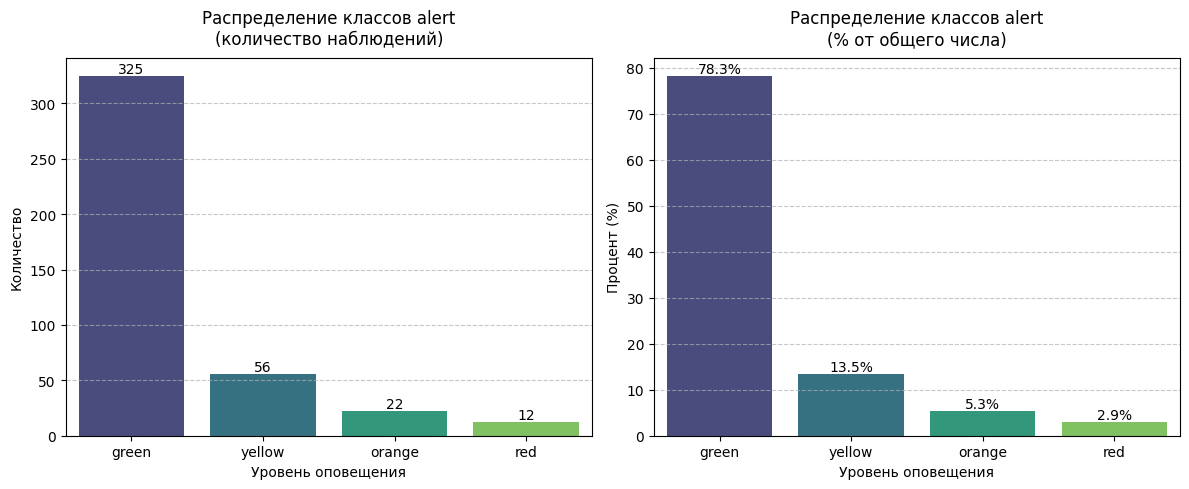


Сводка по распределению классов:
        Количество  Процент (%)
alert                          
green          325        78.31
yellow          56        13.49
orange          22         5.30
red             12         2.89


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def plot_target_distribution(df, target_col="alert", figsize=(12, 5)):
    """
    Строит распределение целевой переменной (классов alert) в виде двух графиков:
    1. Количество наблюдений по классам
    2. Процентное соотношение классов
    
    Parameters:
    -----------
    df : pd.DataFrame
        Датасет с данными
    target_col : str
        Название целевой переменной (по умолчанию 'alert')
    figsize : tuple
        Размер графика (ширина, высота)
    """
    # Создаем фигуру с двумя графиками
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Считаем значения для графиков
    value_counts = df[target_col].value_counts()
    percentages = df[target_col].value_counts(normalize=True) * 100
    
    # График 1: Количество наблюдений
    sns.barplot(x=value_counts.index, y=value_counts.values, 
                palette='viridis', ax=ax1)
    ax1.set_title('Распределение классов alert\n(количество наблюдений)', 
                  fontsize=12, pad=10)
    ax1.set_xlabel('Уровень оповещения')
    ax1.set_ylabel('Количество')
    
    # Добавляем значения над столбцами
    for i, v in enumerate(value_counts.values):
        ax1.text(i, v, str(v), ha='center', va='bottom')
    
    # График 2: Процентное соотношение
    sns.barplot(x=percentages.index, y=percentages.values, 
                palette='viridis', ax=ax2)
    ax2.set_title('Распределение классов alert\n(% от общего числа)', 
                  fontsize=12, pad=10)
    ax2.set_xlabel('Уровень оповещения')
    ax2.set_ylabel('Процент (%)')
    
    # Добавляем процентные значения над столбцами
    for i, v in enumerate(percentages.values):
        ax2.text(i, v, f'{v:.1f}%', ha='center', va='bottom')
    
    # Общие настройки
    for ax in [ax1, ax2]:
        ax.grid(True, linestyle='--', alpha=0.7, axis='y')
        plt.setp(ax.get_xticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Выводим текстовую сводку
    print("\nСводка по распределению классов:")
    summary_df = pd.DataFrame({
        'Количество': value_counts,
        'Процент (%)': percentages
    }).round(2)
    print(summary_df)

plot_target_distribution(df)

**Выводы по распределению целевой переменной:**

Наблюдается существенный дисбаланс классов в исходных данных:

1. Распределение по классам:
   - `green`: 325 наблюдений (78.31%) — доминирующий класс
   - `yellow`: 56 наблюдений (13.49%)
   - `orange`: 22 наблюдения (5.30%)
   - `red`: 12 наблюдений (2.89%) — наиболее редкий класс

2. Рекомендации по работе с дисбалансом:
   - Использовать стратифицированное разбиение при создании train/test выборок (чтобы сохранить пропорции классов)
   - Применить техники балансировки:
     - SMOTE/ADASYN для синтеза дополнительных примеров миноритарных классов (`red`, `orange`)
     - RandomUndersampling для мажоритарного класса (`green`)
     - или комбинированные подходы (SMOTETomek, SMOTEENN)
   
3. Корректировки для обучения:
   - Использовать `class_weight="balanced"` в моделях, поддерживающих взвешивание
   - Оценивать качество по macro/weighted метрикам (F1, ROC-AUC)
   - При необходимости настроить пороги классификации на валидационной выборке

4. Важно: обратить особое внимание на правильную классификацию редких, но критичных классов (`red`, `orange`), так как они могут соответствовать наиболее опасным сейсмическим событиям.

Проверим распределение оставшихся признаков

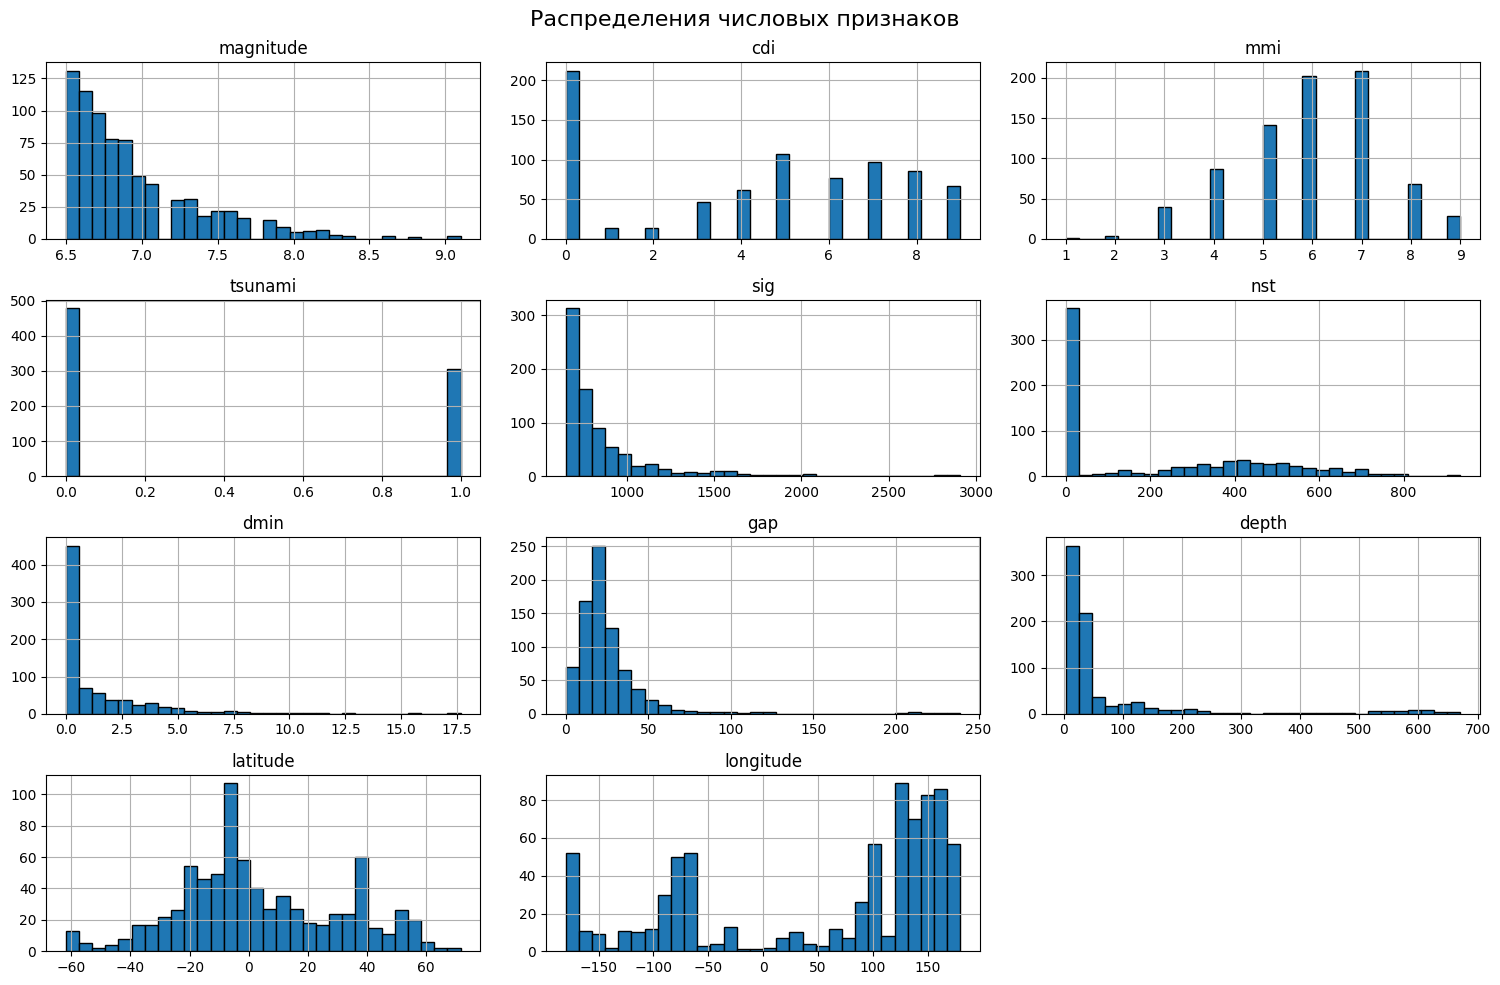

In [15]:
df.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle("Распределения числовых признаков", fontsize=16)
plt.tight_layout()
plt.show()


построим карту с помощью folium где будут отображены точки землетрясений с разным уровнем 

In [16]:
import folium
import pandas as pd

# Цвета для классов alert
alert_colors = {
    "green": "green",
    "yellow": "orange",
    "orange": "red",
    "red": "darkred"
}

# Центр карты — средние координаты
center_lat = df["latitude"].mean()
center_lon = df["longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=2)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=4,
        color=alert_colors.get(str(row["alert"]).lower(), "gray"),
        fill=True,
        fill_color=alert_colors.get(str(row["alert"]).lower(), "gray"),
        fill_opacity=0.7,
        popup=f"Магнитуда: {row['magnitude']}, Alert: {row['alert']}"
    ).add_to(m)

m

Посмотрим на корреляцию данных.

***Определение 1: Корреляция данных — это статистическая мера, показывающая, насколько и в каком направлении связаны между собой две переменные.***

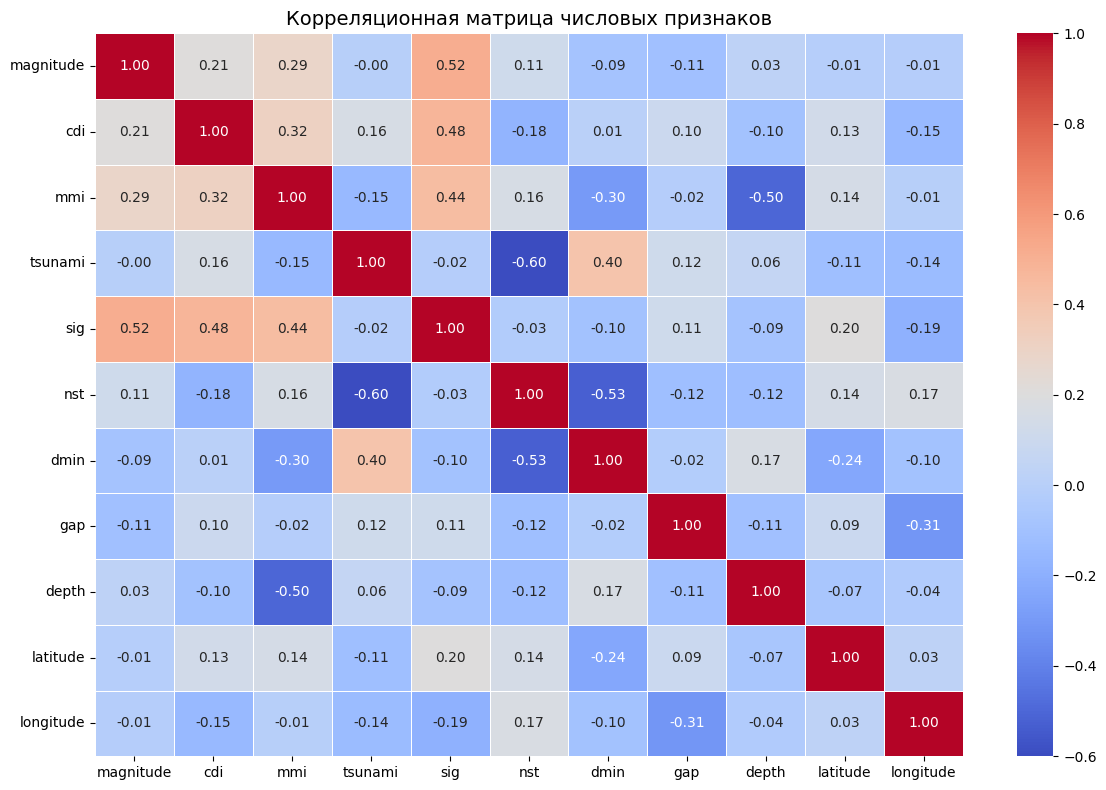

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def draw_corr_matrix(df):
    """
    Строит корреляционную матрицу только для числовых признаков.
    """
    df_numeric = df.select_dtypes(include=['number'])
    plt.figure(figsize=(12, 8))
    corr = df_numeric.corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Корреляционная матрица числовых признаков", fontsize=14)
    plt.tight_layout()
    plt.show()

# Вызов для вашего датасета
draw_corr_matrix(df)

## 📊 1.3. Подготовка датасета под разные модели (Earthquake Alert)

| Модель                  | Масштабирование | Корреляция критична | Выбросы критичны | Feature Engineering рекомендуем                                   |
| ----------------------- | --------------- | ------------------- | ---------------- | ----------------------------------------------------------------- |
| **Логистическая регрессия**  | Да              | Да                  | Да               | Логарифмирование числовых признаков (например, `sig`, `depth`), полиномы по `magnitude`, отношения (`sig/nst`, `depth/magnitude`) |
| **Random Forest**       | Нет             | Нет                 | Нет              | Соотношения (например, `sig/nst`, `depth/magnitude`), бинаризация категориальных признаков (`alert`, если используется как feature) |
| **XGBoost**             | Нет             | Нет                 | Нет              | Соотношения, логарифмирование числовых признаков (опционально), интеракции `magnitude × depth`, `sig × tsunami` |

---

## ✅ TODO для второго человека (Feature Engineering)

1. **Пропуски и выбросы**
   - Заполнить пропуски в категориальных признаках (`country`, `continent`, `alert`) — например, значением `'unknown'` и добавить бинарные индикаторы пропуска.
   - Проверить выбросы в числовых признаках (`depth`, `sig`, `nst`), скорректировать при необходимости (логарифмирование, капирование, удаление экстремумов).

2. **Создание новых признаков**
   - `sig_per_station = sig / nst`
   - `depth_per_magnitude = depth / magnitude`
   - `tsunami_flag = int(tsunami > 0)`

3. **Географические фичи**
   - Закодировать категориальные признаки (`country`, `continent`) через One-Hot Encoding.
   - Опционально: добавить кластеризацию по координатам (`latitude`, `longitude`) для выявления региональных паттернов.

4. **Преобразования целевой переменной**
   - Для задач бинарной классификации: объединить редкие классы (`red`, `orange`) в одну категорию, если требуется.
   - Для многоклассовой: сохранить оригинальные категории, использовать стратификацию при разбиении.

5. **Нормализация**
   - Масштабировать числовые признаки (StandardScaler / MinMaxScaler) — **только для линейных моделей**.
   - Для деревьев и бустингов масштабирование не требуется.

В прошлом пункте мы выяснили, что выраженной линейной зависимостью с таргетом обладает только признак median_income. Построим графики зависимости целевой переменной от признаков, чтобы в этом убедиться.

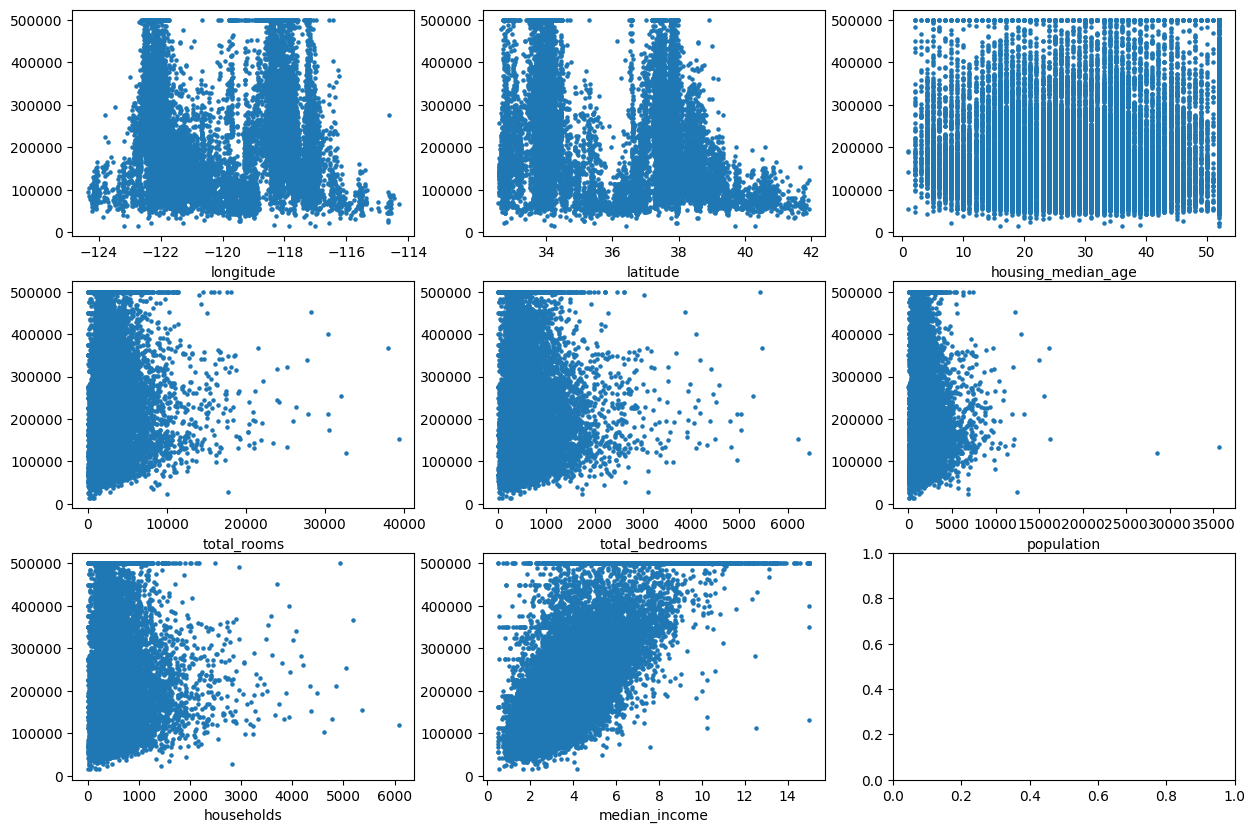

In [ ]:
def plot_dependence(ax, df: pd.DataFrame, feature_col: str, target_col: str):
    df_sorted = df.sort_values(by=feature_col)
    ax.scatter(df_sorted[feature_col], df_sorted[target_col], s=5)
    ax.set_xlabel(feature_col)


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

for i, feature in enumerate(df.select_dtypes('number').drop('median_house_value', axis=1)):
    plot_dependence(axes[i // 3][i % 3], df, feature, 'median_house_value')


*Мысли*:

1. Очевидно, что долгота и широта на цену напрямую не влияют. Влияет то, в каком районе расположен дом. Значит нужно сделать разбиение этой области, подсчитать среднее или медиану в каждом отрезке разбиения и заменить оба признака на новый признак.
2. Признак totalRooms не несёт эффективной информации, так как он не учитывает численность населения в пределах квартала. Значит, можно заменить этот признак на totalRooms / population
3. Аналогичная история с totalBedrooms. Однако, мы уже выяснили что totalBedrooms и totalRooms линейно зависимы. Нужно проверить, зависимы ли "плотности", и в случае зависимости добавить только признак totalRooms / totalBedrooms, т.к. иметь много спален в одном доме бесмысленно, если там живёт мало человек, но иметь много комнат могут себе позволить только богатые люди.
4. Не уверен в надобности признака households, потому что он сильно зависит от population, но можно добавить признак population / households - средний размер домохозяйства.


Также нужно заполнить пропуски в total_bedrooms. К сожалению понять, имеют ли пропуски физический смысл (отсутствие спален в техническом помещении), не получится - так как остальные признаки аггрегированы по целому кварталу. Поэтому предлагаю заменить пропуски медианов и не париться

In [ ]:
df_modified = df.copy()
df_modified['total_bedrooms'] = df_modified['total_bedrooms'].fillna(
    df_modified['total_bedrooms'].median())


Начнём с простого, добавим признаки rooms_per_people, bedrooms_ratio, households_size:

In [ ]:
df_modified['rooms_per_people'] = df_modified['total_rooms'] / \
    df_modified['population']
df_modified['bedrooms_ratio'] = df_modified['total_rooms'] / \
    df_modified['total_bedrooms']
df_modified['households_size'] = df_modified['population'] / \
    df_modified['households']


Теперь напишем класс для обработки признаков longitude и latitude

In [ ]:
import numpy as np


class GridMedianTransformer:
    def __init__(self, n_bins=100, target_col="median_house_value", new_feature_name="grid_median_value"):
        """
        n_bins: количество ячеек по каждой оси (по умолчанию 100 → 100x100 сетка)
        target_col: имя целевой переменной в обучающем датасете (для расчёта медиан)
        new_feature_name: имя нового признака в выходном DataFrame
        """
        self.n_bins = n_bins
        self.target_col = target_col
        self.new_feature_name = new_feature_name
        self.lat_edges = None
        self.lon_edges = None
        self.grid_medians = None  # Series с мультииндексом (lat_bin, lon_bin)
        self.global_median = None

    def fit(self, X, y=None):
        """
        X: DataFrame с колонками 'latitude', 'longitude' и (если y=None) target_col
        y: опционально — отдельный Series с целевой переменной
        """
        df = X.copy()

        if y is not None:
            df[self.target_col] = y.values
        elif self.target_col not in df.columns:
            raise ValueError(
                f"Target column '{self.target_col}' must be in X or provided via y")

        # Сохраняем глобальную медиану на случай точек вне сетки
        self.global_median = df[self.target_col].median()

        # Границы бинов — фиксируем по обучающим данным
        self.lat_edges = np.linspace(
            df["latitude"].min(), df["latitude"].max(), self.n_bins + 1)
        self.lon_edges = np.linspace(
            df["longitude"].min(), df["longitude"].max(), self.n_bins + 1)

        # Бинируем координаты
        df["lat_bin"] = pd.cut(
            df["latitude"], bins=self.lat_edges, labels=False, include_lowest=True)
        df["lon_bin"] = pd.cut(
            df["longitude"], bins=self.lon_edges, labels=False, include_lowest=True)

        # Удаляем строки, где бин не определён (маловероятно, но возможно)
        df = df.dropna(subset=["lat_bin", "lon_bin"]).copy()
        df["lat_bin"] = df["lat_bin"].astype(int)
        df["lon_bin"] = df["lon_bin"].astype(int)

        # Агрегация: медиана по ячейкам
        self.grid_medians = (
            df.groupby(["lat_bin", "lon_bin"])[self.target_col]
            .median()
        )
        return self

    def transform(self, X):
        """
        X: DataFrame с колонками 'latitude', 'longitude'
        Возвращает: новый DataFrame без 'latitude', 'longitude',
                    с добавленной колонкой self.new_feature_name
        """
        if self.lat_edges is None or self.lon_edges is None:
            raise ValueError(
                "Transformer has not been fitted yet. Call fit() first.")

        df = X.copy()

        # Бинируем новые координаты теми же границами
        lat_bins = pd.cut(df["latitude"], bins=self.lat_edges,
                          labels=False, include_lowest=True)
        lon_bins = pd.cut(df["longitude"], bins=self.lon_edges,
                          labels=False, include_lowest=True)

        # Преобразуем в целые числа, NaN остаются как NaN
        lat_bins = pd.to_numeric(lat_bins, errors='coerce').astype('Int64')
        lon_bins = pd.to_numeric(lon_bins, errors='coerce').astype('Int64')

        # Создаём индекс для поиска в grid_medians
        idx = pd.MultiIndex.from_arrays(
            [lat_bins, lon_bins], names=["lat_bin", "lon_bin"])

        # Получаем медианы; где нет — будет NaN
        medians = self.grid_medians.reindex(idx).values

        # Заполняем пропуски глобальной медианой
        medians = np.where(pd.isna(medians), self.global_median, medians)

        # Формируем результат: копируем все колонки, кроме координат
        result_df = df.drop(columns=["latitude", "longitude"]).copy()
        result_df[self.new_feature_name] = medians

        return result_df


In [ ]:
grid_transformer = GridMedianTransformer(
    target_col='median_house_value', new_feature_name='grid_median_value')
grid_transformer.fit(df_modified)
df_modified = grid_transformer.transform(df_modified)


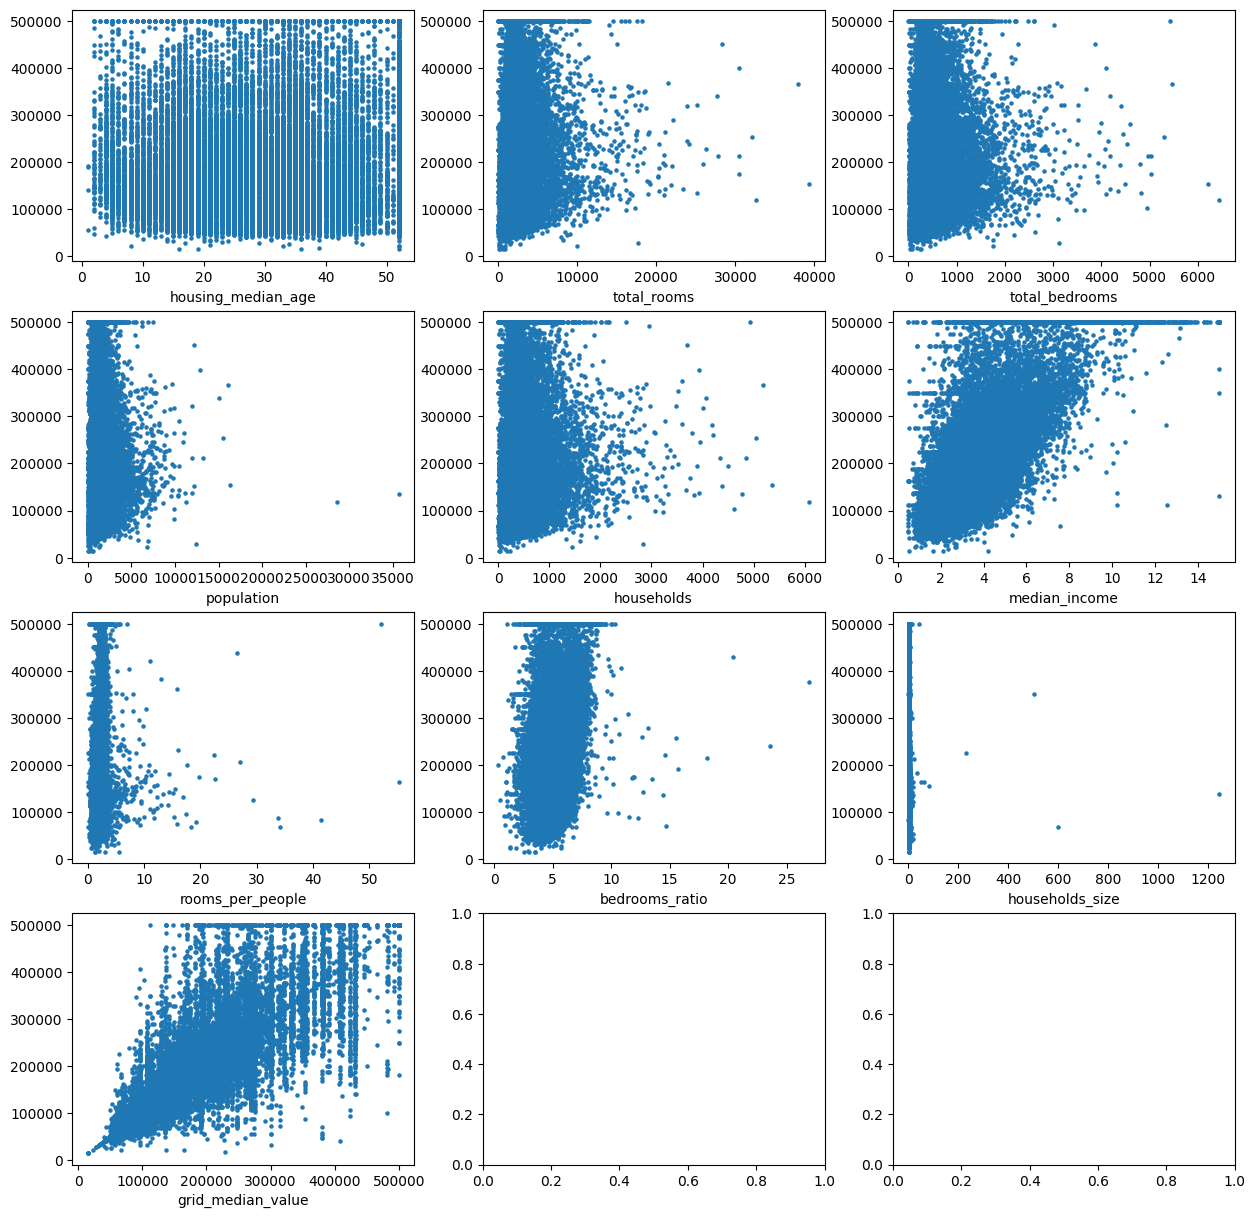

In [ ]:
def plot_dependence(ax, df: pd.DataFrame, feature_col: str, target_col: str):
    df_sorted = df.sort_values(by=feature_col)
    ax.scatter(df_sorted[feature_col], df_sorted[target_col], s=5)
    ax.set_xlabel(feature_col)


fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

for i, feature in enumerate(df_modified.select_dtypes('number').drop('median_house_value', axis=1)):
    plot_dependence(axes[i // 3][i % 3], df_modified,
                    feature, 'median_house_value')


В households_size, bedrooms_ratio и rooms_per_people какие-то адские выбросы. Попробуем их убрать

In [ ]:
def remove_outliers_by_percentile(
    df,
    columns=None,
    lower_percentile=1,
    upper_percentile=99,
    return_bounds=False
):
    """
    Удаляет строки из DataFrame, где хотя бы один из указанных признаков
    выходит за пределы [lower_percentile, upper_percentile].

    Параметры:
    ----------
    df : pd.DataFrame
        Исходный датасет.
    columns : list или None
        Список колонок для проверки на выбросы.
        Если None — используются все числовые колонки.
    lower_percentile : float, по умолчанию 5
        Нижний процентиль (например, 5 = 5%).
    upper_percentile : float, по умолчанию 95
        Верхний процентиль (например, 95 = 95%).
    return_bounds : bool, по умолчанию False
        Если True, возвращает также словарь с границами.

    Возвращает:
    ----------
    df_clean : pd.DataFrame
        DataFrame без строк-выбросов.
    bounds (опционально) : dict
        {col: (low, high), ...} — границы для каждой колонки.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")

    if not (0 <= lower_percentile < upper_percentile <= 100):
        raise ValueError("Percentiles must satisfy 0 <= lower < upper <= 100")

    # Определяем колонки для обработки
    if columns is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    else:
        missing = set(columns) - set(df.columns)
        if missing:
            raise ValueError(f"Columns not found in DataFrame: {missing}")
        cols = columns

    if not cols:
        raise ValueError("No numeric columns to process")

    # Вычисляем границы на основе исходного df
    bounds = {}
    mask = pd.Series([True] * len(df), index=df.index)

    for col in cols:
        low = df[col].quantile(lower_percentile / 100)
        high = df[col].quantile(upper_percentile / 100)
        bounds[col] = (low, high)
        # Обновляем маску: оставляем только те строки, где значение в пределах
        mask &= (df[col] >= low) & (df[col] <= high)

    df_clean = df[mask].copy()

    if return_bounds:
        return df_clean, bounds
    else:
        return df_clean


In [ ]:
df_modified_clean = remove_outliers_by_percentile(df_modified, columns=[
                                                  'households_size', 'rooms_per_people', 'bedrooms_ratio'], lower_percentile=1, upper_percentile=99)


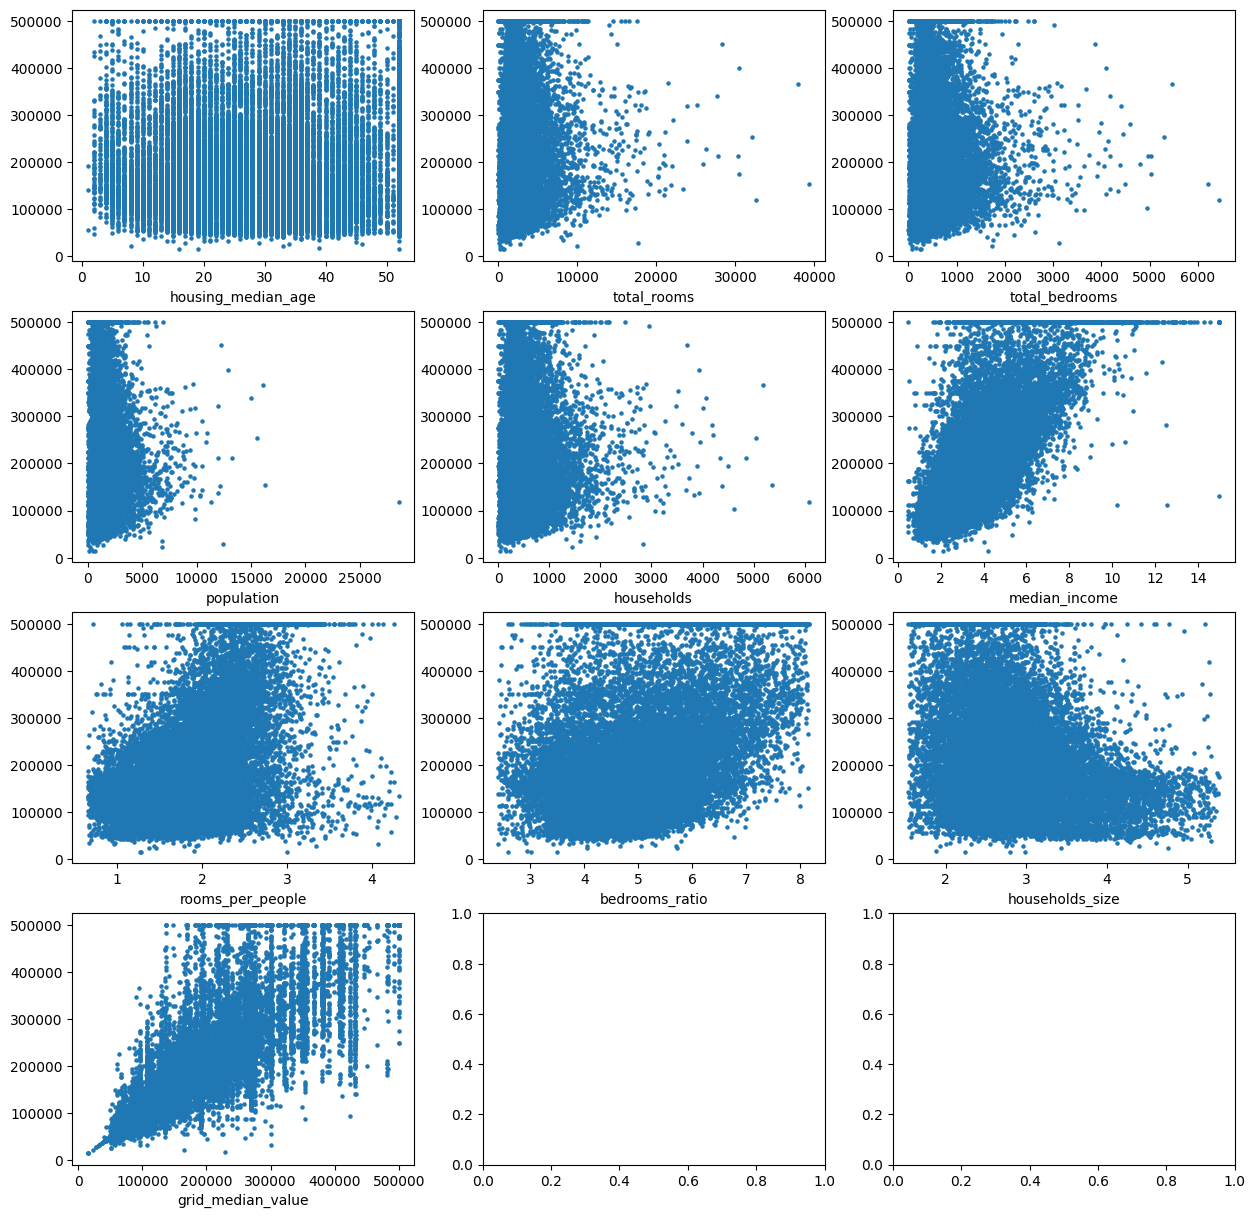

In [ ]:
def plot_dependence(ax, df: pd.DataFrame, feature_col: str, target_col: str):
    df_sorted = df.sort_values(by=feature_col)
    ax.scatter(df_sorted[feature_col], df_sorted[target_col], s=5)
    ax.set_xlabel(feature_col)


fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

for i, feature in enumerate(df_modified_clean.select_dtypes('number').drop('median_house_value', axis=1)):
    plot_dependence(axes[i // 3][i % 3], df_modified_clean,
                    feature, 'median_house_value')


в households_size что-то отдалённо напоминающее гиперболу, давайте поменяем соотношение, чтобы получить прямую зависимость

In [ ]:
df_modified_clean['households_size'] = df_modified['households'] / \
    df_modified['population']
df_modified_clean = remove_outliers_by_percentile(df_modified_clean, columns=[
                                                  'households_size'], lower_percentile=1, upper_percentile=99)


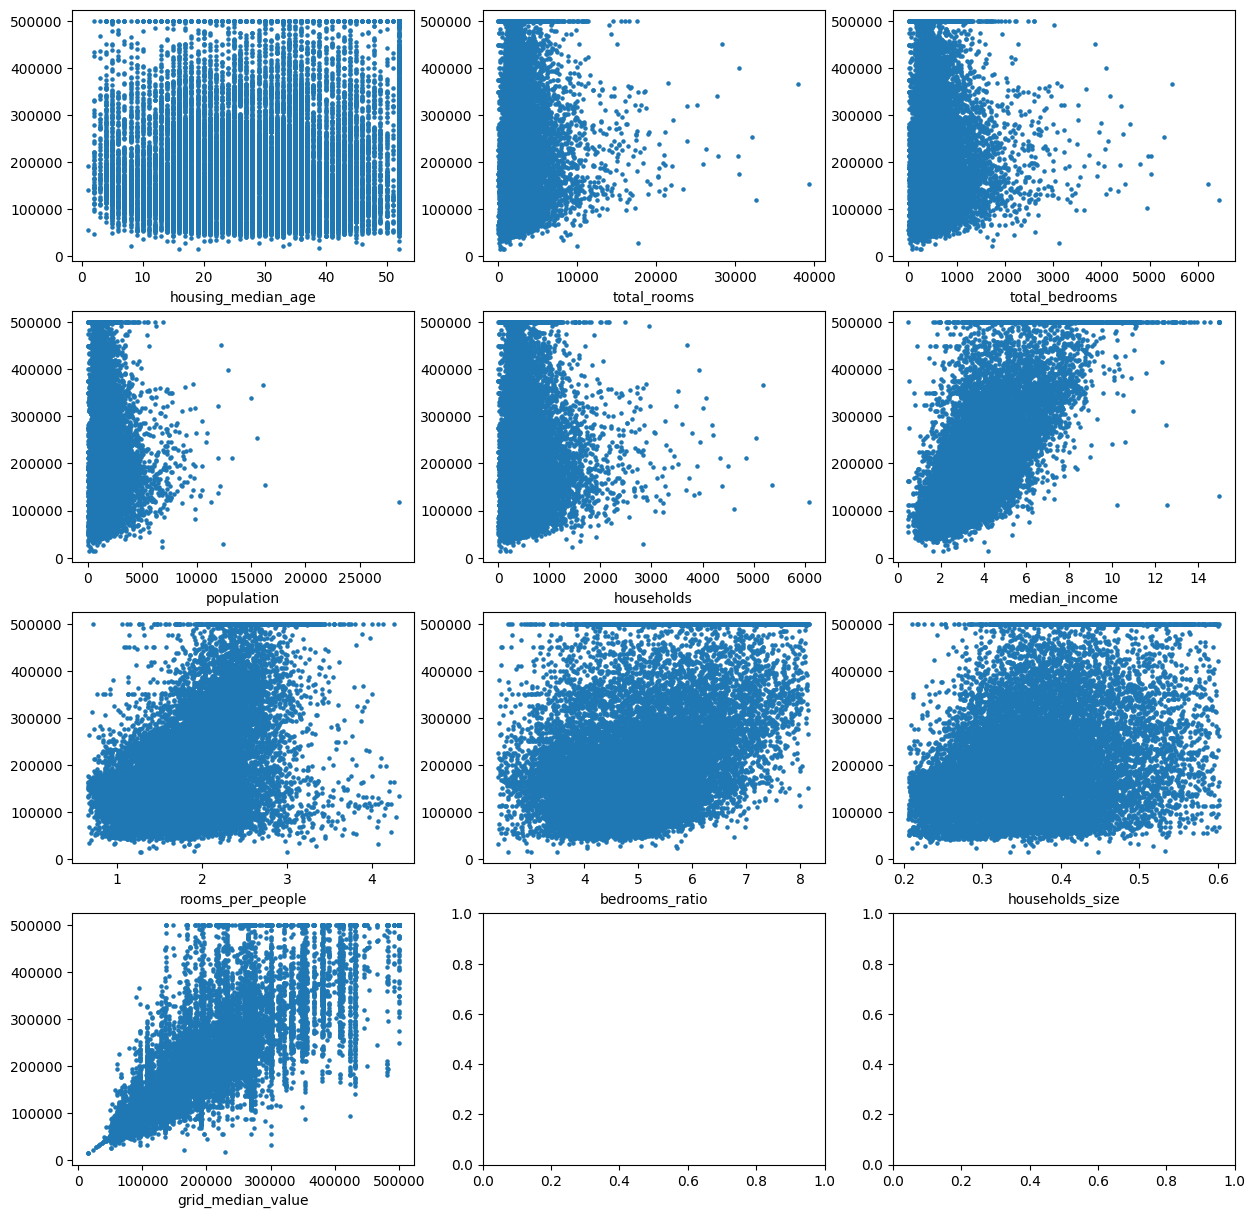

In [ ]:
def plot_dependence(ax, df: pd.DataFrame, feature_col: str, target_col: str):
    df_sorted = df.sort_values(by=feature_col)
    ax.scatter(df_sorted[feature_col], df_sorted[target_col], s=5)
    ax.set_xlabel(feature_col)


fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

for i, feature in enumerate(df_modified_clean.select_dtypes('number').drop('median_house_value', axis=1)):
    plot_dependence(axes[i // 3][i % 3], df_modified_clean,
                    feature, 'median_house_value')


Наконец, давайте сделаем OneHotEncoding для единственного категориального признака, так как в нём совсем немного уникальных значений:

In [ ]:
set(df['ocean_proximity'].values)


{'<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'}

In [ ]:
df_modified_clean.isna().sum()


housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
rooms_per_people      0
bedrooms_ratio        0
households_size       0
grid_median_value     0
dtype: int64

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe_encoder = OneHotEncoder(sparse_output=False)
encoded_df = ohe_encoder.fit_transform(df_modified_clean[['ocean_proximity']])

# Получаем имена новых столбцов
feature_names = ohe_encoder.get_feature_names_out(['ocean_proximity'])

# Преобразуем обратно в DataFrame
df_result = pd.concat([
    df_modified_clean.select_dtypes(include='number'),
    pd.DataFrame(encoded_df, columns=feature_names,
                 index=df_modified_clean.index)
], axis=1)
df_result


,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_people,bedrooms_ratio,households_size,grid_median_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,2.732919,6.821705,0.391304,367100.0,0.0,0.0,0.0,1.0,0.0
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,2.956685,6.418626,0.473969,367100.0,0.0,0.0,0.0,1.0,0.0
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,2.957661,7.721053,0.356855,367100.0,0.0,0.0,0.0,1.0,0.0
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,2.283154,5.421277,0.392473,191700.0,0.0,0.0,0.0,1.0,0.0
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,2.879646,5.810714,0.458407,191700.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,1.970414,4.451872,0.390533,78100.0,0.0,1.0,0.0,0.0,0.0
20636,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,1.957865,4.646667,0.320225,84700.0,0.0,1.0,0.0,0.0,0.0
20637,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,2.238332,4.647423,0.429990,84700.0,0.0,1.0,0.0,0.0,0.0
20638,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,2.510121,4.547677,0.470985,84700.0,0.0,1.0,0.0,0.0,0.0


# 3. Обучение стандартных моделей и Написание своего класса Линейной Регрессии


##  3.1. Отложенная выборка и скейлинг

In [ ]:
from sklearn.model_selection import train_test_split


X, y = df_result.drop(columns=['median_house_value']
                      ), df_result['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RND_SEED)


In [ ]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(
    X_train), scaler.transform(X_test)


## 3.2. Метрики

In [ ]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)


def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))


def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


def r2(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))


def get_metrics(y_true, y_pred):
    return {
        'MSE': mse(y_true, y_pred),
        'RMSE': rmse(y_true, y_pred),
        'MAE': mae(y_true, y_pred),
        'R2': r2(y_true, y_pred),
    }


## 3.3. Обучение базовых моделей

### 3.3.1. Линейная регрессия (Аналитическое решение)

In [ ]:
from sklearn.linear_model import LinearRegression


model_as = LinearRegression()
model_as.fit(X_train_scaled, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [ ]:
y_pred = model_as.predict(X_test_scaled)
metrics_as = get_metrics(y_test, y_pred)
metrics_as


{'MSE': np.float64(2710837523.242142),
 'RMSE': np.float64(52065.70390614288),
 'MAE': np.float64(36251.33855939497),
 'R2': np.float64(0.7915664666849189)}

### 3.3.2. Линейная регрессия (ГД)

In [ ]:
from sklearn.linear_model import SGDRegressor


model_gd = SGDRegressor(
    max_iter=2000,
    tol=1e-6,
    learning_rate='constant',
    eta0=1e-4,
    penalty='l2',
    shuffle=False,
    random_state=RND_SEED
)
model_gd.fit(X_train_scaled, y_train)


,loss,'squared_error'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,2000
,tol,1e-06
,shuffle,False
,verbose,0
,epsilon,0.1
,random_state,42


In [ ]:
y_pred = model_gd.predict(X_test_scaled)
metrics_gd = get_metrics(y_test, y_pred)
metrics_gd


{'MSE': np.float64(2710075873.080366),
 'RMSE': np.float64(52058.38907496433),
 'MAE': np.float64(36226.32276377795),
 'R2': np.float64(0.7916250291893139)}

### 3.3.3. Линейная регрессия (CГД)

In [ ]:
model_sgd = SGDRegressor(
    max_iter=3000,
    tol=1e-6,
    learning_rate='invscaling',
    eta0=1e-4,
    penalty='l1',
    random_state=RND_SEED
)
model_sgd.fit(X_train_scaled, y_train)


,loss,'squared_error'
,penalty,'l1'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,3000
,tol,1e-06
,shuffle,True
,verbose,0
,epsilon,0.1
,random_state,42


In [ ]:
y_pred = model_sgd.predict(X_test_scaled)
metrics_sgd = get_metrics(y_test, y_pred)
metrics_sgd


{'MSE': np.float64(2708582060.473625),
 'RMSE': np.float64(52044.03962485642),
 'MAE': np.float64(36235.231687688174),
 'R2': np.float64(0.7917398869176226)}

### 3.3.4. Линейная регрессия (Ridge)

In [ ]:
from sklearn.linear_model import Ridge


model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train_scaled, y_train)


,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [ ]:
y_pred = model_ridge.predict(X_test_scaled)
metrics_ridge = get_metrics(y_test, y_pred)
metrics_ridge


{'MSE': np.float64(2710809461.7334886),
 'RMSE': np.float64(52065.4344237469),
 'MAE': np.float64(36251.32957035499),
 'R2': np.float64(0.791568624305709)}

### 3.3.5. Линейная регрессия (Lasso)

In [ ]:
from sklearn.linear_model import Lasso


model_lasso = Lasso(alpha=0.05, max_iter=100_000)
model_lasso.fit(X_train_scaled, y_train)


,alpha,0.05
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,100000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [ ]:
y_pred = model_lasso.predict(X_test_scaled)
metrics_lasso = get_metrics(y_test, y_pred)
metrics_lasso


{'MSE': np.float64(2710830159.3905005),
 'RMSE': np.float64(52065.63318918248),
 'MAE': np.float64(36251.26127997948),
 'R2': np.float64(0.7915670328839638)}

### 3.3.6. Линейная регрессия (ElasticNet)

In [ ]:
from sklearn.linear_model import ElasticNet


model_enet = ElasticNet(alpha=0.05, l1_ratio=0.5)
model_enet.fit(X_train_scaled, y_train)


,alpha,0.05
,l1_ratio,0.5
,fit_intercept,True
,precompute,False
,max_iter,1000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [ ]:
y_pred = model_enet.predict(X_test_scaled)
metrics_enet = get_metrics(y_test, y_pred)
metrics_enet


{'MSE': np.float64(2715303013.6153936),
 'RMSE': np.float64(52108.56948348701),
 'MAE': np.float64(36368.08159875065),
 'R2': np.float64(0.791223119682931)}

### 3.3.7. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor


model_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=RND_SEED,
    n_jobs=-1
)
model_rf.fit(X_train, y_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
y_pred = model_rf.predict(X_test)
metrics_rf = get_metrics(y_test, y_pred)
metrics_rf


{'MSE': np.float64(1976786565.7899678),
 'RMSE': np.float64(44461.06797851315),
 'MAE': np.float64(28579.885691766543),
 'R2': np.float64(0.8480068963983483)}

## 3.4. Свой класс Линейной регрессии

### 3.4.1. Класс

In [ ]:
from typing import Literal


class LinReg:
    """
    Линейная регрессия на NumPy.
    Методы обучения:
      - 'analytic' : нормальные уравнения
      - 'gd'       : градиентный спуск (полный батч)
      - 'sgd'      : стохастический ГД (по одному объекту)
    Гиперпараметры:
      - method: 'analytic' | 'gd' | 'sgd'
      - eta: шаг обучения (для gd/sgd)
      - max_iter: число эпох (для gd/sgd)
    """

    def __init__(
        self,
        method: Literal['analytic', 'gd', 'sgd'] = 'analytic',
        eta: float = 1e-2,
        max_iter: int = 1000,
        random_state: int = 42,
    ) -> None:
        self.method = method
        self.eta = float(eta)
        self.max_iter = int(max_iter)
        self.random_state = int(random_state)

        self.coef_: np.ndarray | None = None
        self.intercept_: float = 0.0
        self.history_: list[float] = []

        self._rng = np.random.default_rng(self.random_state)

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'LinReg':
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).ravel()
        if X.ndim != 2:
            raise ValueError(
                'X должен быть двумерным (n_samples, n_features).')
        if X.shape[0] != y.shape[0]:
            raise ValueError('Число строк X и длина y должны совпадать.')
        if not (np.isfinite(X).all() and np.isfinite(y).all()):
            raise ValueError('X/y содержат NaN/Inf.')

        n, d = X.shape
        self.history_.clear()

        if self.method == 'analytic':
            Xb = np.hstack([np.ones((n, 1)), X])
            theta = np.linalg.pinv(Xb, rcond=1e-12) @ y
            self.intercept_ = float(theta[0])
            self.coef_ = theta[1:].astype(float)
            return self

        w = self._rng.normal(0.0, 0.01, size=d)
        b = 0.0

        if self.method == 'gd':
            for _ in range(self.max_iter):
                y_hat = X @ w + b
                diff = y_hat - y

                grad_w = 2.0 * (X.T @ diff) / n
                grad_b = 2.0 * float(np.mean(diff))

                w -= self.eta * grad_w
                b -= self.eta * grad_b

                self.history_.append(float(np.mean(diff**2)))
            self.coef_, self.intercept_ = w.astype(float), float(b)
            return self

        if self.method == 'sgd':
            idx = np.arange(n)
            gclip = 1e6
            for epoch in range(self.max_iter):
                self._rng.shuffle(idx)
                eta_t = self.eta / np.sqrt(epoch + 1.0)

                for i in idx:
                    xi = X[i]
                    yi = y[i]
                    y_hat_i = float(xi @ w + b)
                    e = y_hat_i - yi

                    grad_w = 2.0 * e * xi
                    grad_b = 2.0 * e

                    grad_w = np.clip(grad_w, -gclip, gclip)
                    grad_b = float(np.clip(grad_b, -gclip, gclip))

                    w -= eta_t * grad_w
                    b -= eta_t * grad_b

                if not (np.isfinite(w).all() and np.isfinite(b)):
                    raise FloatingPointError(
                        "Веса взорвались. Попробуйте меньшее eta."
                    )

                diff_epoch = (X @ w + b) - y
                diff_safe = np.clip(diff_epoch, -1e150, 1e150)
                self.history_.append(float(np.mean(diff_safe * diff_safe)))

            self.coef_, self.intercept_ = w.astype(float), float(b)
            return self

        raise ValueError("method должен быть 'analytic', 'gd' или 'sgd'.")

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.coef_ is None:
            raise RuntimeError('Сначала вызови fit().')
        X = np.asarray(X, dtype=float)
        return (self.intercept_ + X @ self.coef_).astype(float)

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        """R^2 как в sklearn."""
        y = np.asarray(y, dtype=float).ravel()
        y_pred = self.predict(X).ravel()
        ss_res = float(np.sum((y - y_pred) ** 2))
        ss_tot = float(np.sum((y - np.mean(y)) ** 2))
        return 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0


### 3.4.2. Аналитическое решение

In [ ]:
model_lr_as = LinReg(method='analytic', random_state=RND_SEED)
model_lr_as.fit(X_train_scaled, y_train)


In [ ]:
y_pred = model_lr_as.predict(X_test_scaled)
metrics_lr_as = get_metrics(y_test, y_pred)
metrics_lr_as


{'MSE': np.float64(2710837523.2421417),
 'RMSE': np.float64(52065.70390614288),
 'MAE': np.float64(36251.33855939498),
 'R2': np.float64(0.7915664666849189)}

### 3.4.3. ГД

In [ ]:
model_lr_gd = LinReg(method='gd', random_state=RND_SEED)
model_lr_gd.fit(X_train_scaled, y_train)


In [ ]:
y_pred = model_lr_gd.predict(X_test_scaled)
metrics_lr_gd = get_metrics(y_test, y_pred)
metrics_lr_gd


{'MSE': np.float64(2706813991.7032976),
 'RMSE': np.float64(52027.05057663078),
 'MAE': np.float64(36222.330319098626),
 'R2': np.float64(0.7918758319227304)}

### 3.4.4. CГД

In [ ]:
model_lr_sgd = LinReg(method='sgd', eta=1e-4, random_state=RND_SEED)
model_lr_sgd.fit(X_train_scaled, y_train)


In [ ]:
y_pred = model_lr_sgd.predict(X_test_scaled)
metrics_lr_sgd = get_metrics(y_test, y_pred)
metrics_lr_sgd


{'MSE': np.float64(2706021207.84466),
 'RMSE': np.float64(52019.4310603707),
 'MAE': np.float64(36234.50811992017),
 'R2': np.float64(0.7919367882653345)}

## 3.5. Сравнение метрик

In [ ]:
method2metrics = {
    'analytic': metrics_as,
    'class_analytic': metrics_lr_as,
    'gd': metrics_gd,
    'class_gd': metrics_lr_gd,
    'sgd': metrics_sgd,
    'class_sgd': metrics_lr_sgd,
    'Ridge': metrics_ridge,
    'Lasso': metrics_lasso,
    'ElasticNet': metrics_enet,
    'RandomForest': metrics_rf,
}

norm = {}
for method, md in method2metrics.items():
    norm[method] = {k: (float(v) if isinstance(
        v, (np.floating, float, int)) else v) for k, v in md.items()}

df = pd.DataFrame.from_dict(norm, orient='index')

desired = ['MSE', 'RMSE', 'MAE', 'R2']
cols = [c for c in desired if c in df.columns] + \
    [c for c in df.columns if c not in desired]
df = df[cols]

df.index.name = 'method'
df.to_csv('metrics.csv', index=True, float_format="%.6f")

print(df)


                         MSE          RMSE           MAE        R2
method                                                            
analytic        2.710838e+09  52065.703906  36251.338559  0.791566
class_analytic  2.710838e+09  52065.703906  36251.338559  0.791566
gd              2.710076e+09  52058.389075  36226.322764  0.791625
class_gd        2.706814e+09  52027.050577  36222.330319  0.791876
sgd             2.708582e+09  52044.039625  36235.231688  0.791740
class_sgd       2.706021e+09  52019.431060  36234.508120  0.791937
Ridge           2.710809e+09  52065.434424  36251.329570  0.791569
Lasso           2.710830e+09  52065.633189  36251.261280  0.791567
ElasticNet      2.715303e+09  52108.569483  36368.081599  0.791223
RandomForest    1.976787e+09  44461.067979  28579.885692  0.848007


## 3.5. Feature Importance

### 3.5.1. Аналитическое решение

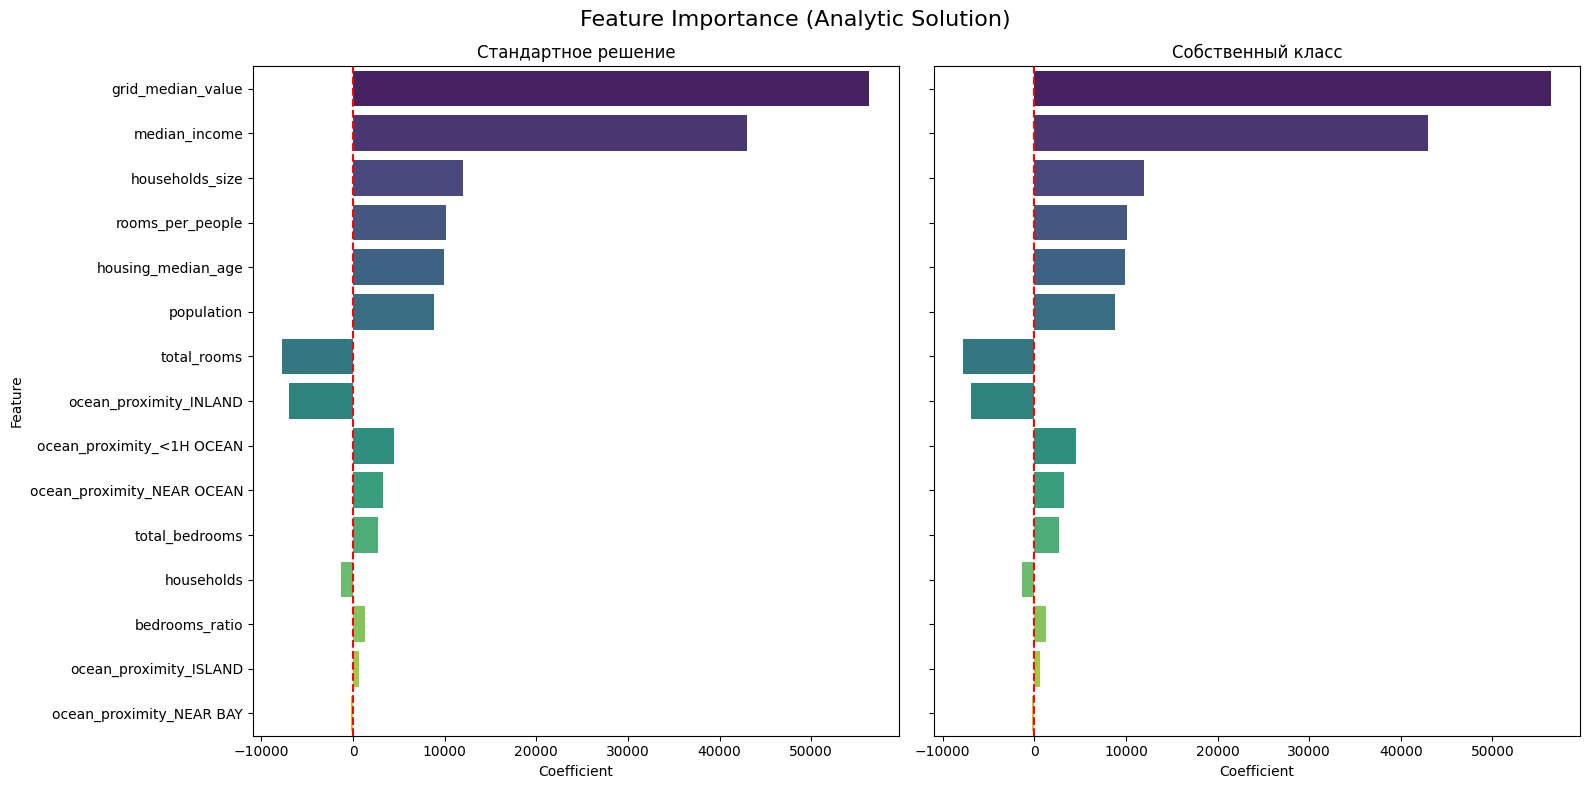

In [ ]:
importance_as = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model_as.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

importance_lr_as = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model_lr_as.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

sns.barplot(
    x="Coefficient", y="Feature",
    data=importance_as,
    palette="viridis",
    ax=axes[0],
    hue='Feature',
    legend=False,
)
axes[0].set_title("Стандартное решение")
axes[0].axvline(0, color="red", linestyle="--")

sns.barplot(
    x="Coefficient", y="Feature",
    data=importance_lr_as,
    palette="viridis",
    ax=axes[1],
    hue='Feature',
    legend=False,
)
axes[1].set_title("Собственный класс")
axes[1].axvline(0, color="red", linestyle="--")

plt.suptitle("Feature Importance (Analytical Solution)", fontsize=16)
plt.tight_layout()
plt.show()


### 3.5.2. Градиентный спуск

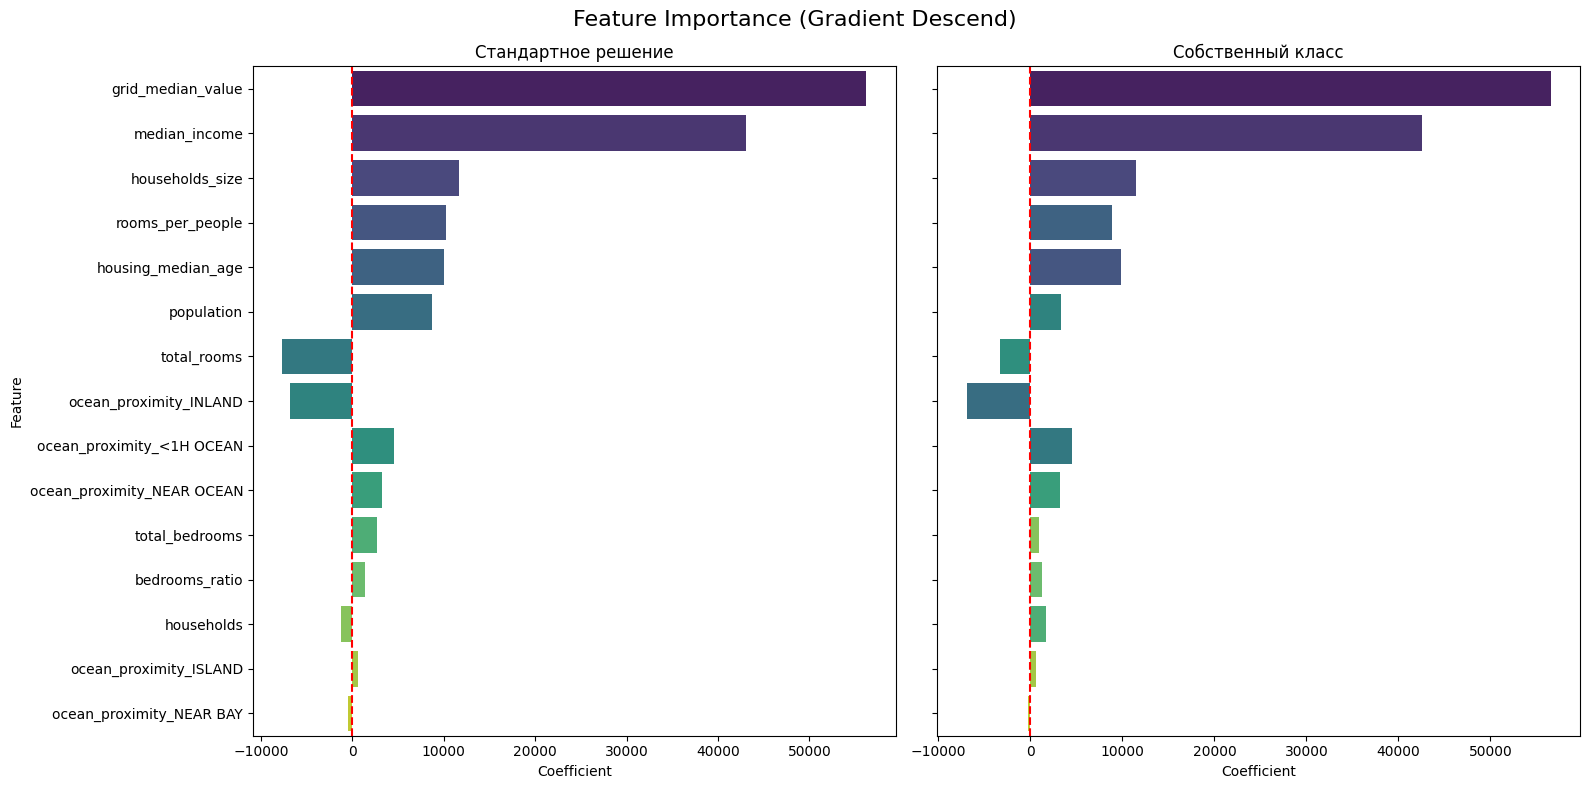

In [ ]:
importance_as = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model_gd.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

importance_lr_as = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model_lr_gd.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

sns.barplot(
    x="Coefficient", y="Feature",
    data=importance_as,
    palette="viridis",
    ax=axes[0],
    hue='Feature',
    legend=False,
)
axes[0].set_title("Стандартное решение")
axes[0].axvline(0, color="red", linestyle="--")

sns.barplot(
    x="Coefficient", y="Feature",
    data=importance_lr_as,
    palette="viridis",
    ax=axes[1],
    hue='Feature',
    legend=False,
)
axes[1].set_title("Собственный класс")
axes[1].axvline(0, color="red", linestyle="--")

plt.suptitle("Feature Importance (Gradient Descend)", fontsize=16)
plt.tight_layout()
plt.show()


### 3.5.3. Стохастический градиентный спуск

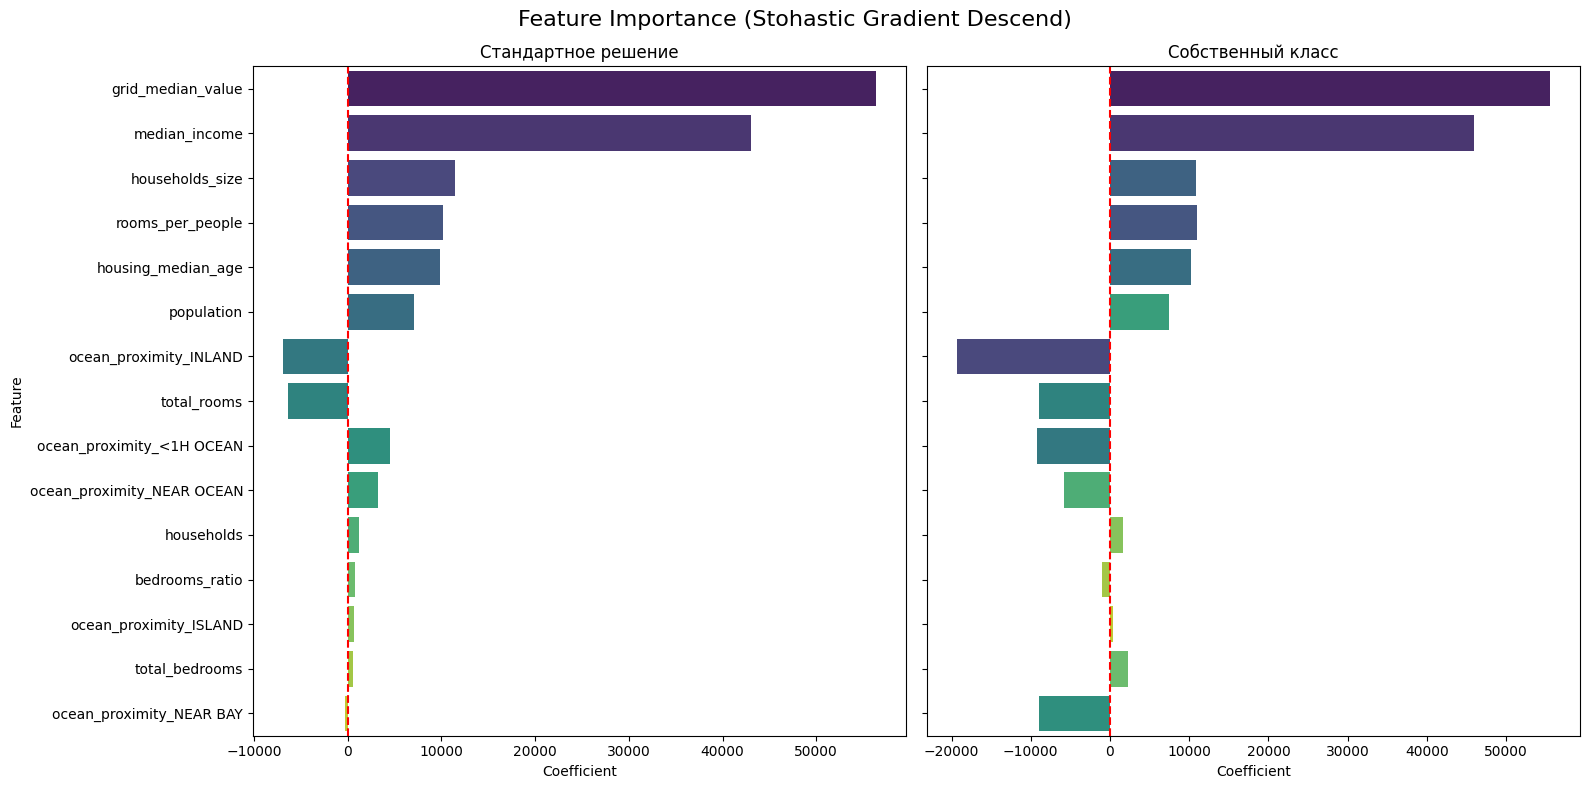

In [ ]:
importance_as = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model_sgd.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

importance_lr_as = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model_lr_sgd.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

sns.barplot(
    x="Coefficient", y="Feature",
    data=importance_as,
    palette="viridis",
    ax=axes[0],
    hue='Feature',
    legend=False,
)
axes[0].set_title("Стандартное решение")
axes[0].axvline(0, color="red", linestyle="--")

sns.barplot(
    x="Coefficient", y="Feature",
    data=importance_lr_as,
    palette="viridis",
    ax=axes[1],
    hue='Feature',
    legend=False,
)
axes[1].set_title("Собственный класс")
axes[1].axvline(0, color="red", linestyle="--")

plt.suptitle("Feature Importance (Stohastic Gradient Descend)", fontsize=16)
plt.tight_layout()
plt.show()
